# Procesamiento del Lenguaje Natural
* <font size=5px>**Similaridad de Palabras en un corpus**</font>
* <font size=4px>**Word2vec, representacion del significado de una palabra dado un contexto**</font>

## Conceptos

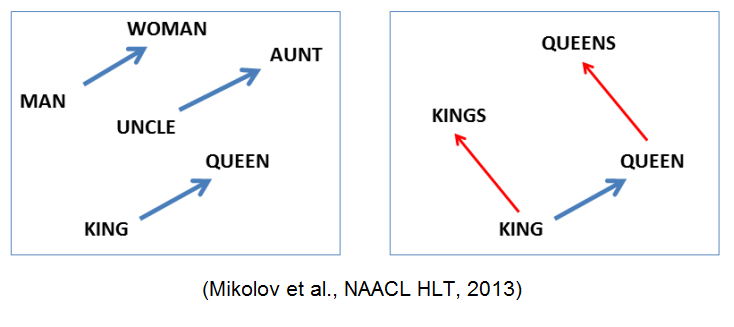

In [724]:
from IPython.display import Image
Image("images/word2vec.png")

Word2vec está formado por dos modelos:

- Skip-gram
- Continuous Bag-of-Words (CBOW)

Su tarea es: Aprender de modo eficiente una representación vetorial de palabras a partir de un corpus no-extruturado. El aprendizado se da atraves de las estadísticas de co-ocorrencia de las palabras en el corpus. 

Entonces, dado un corpus, escogemos:

- Un vocabulário V.
- Un tamanho N para la representacíon vetorial de las palabras.

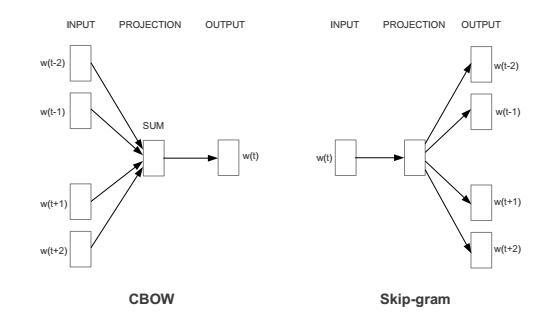

In [725]:
from IPython.display import Image
Image("images/cbowskip.png")

## Imports

In [726]:
# Imports
import os
import csv
import collections
import math
import random
import bz2
import nltk
import operator
import numpy as np
import tensorflow as tf
import matplotlib
import sklearn
from matplotlib import pylab
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from math import ceil

# Desactivando los mensajes de avisos/warnings de matplotlib
import sys
import warnings
import matplotlib.cbook
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=matplotlib.cbook.mplDeprecation)

%matplotlib inline

In [728]:
# Controlando la version del TF
import tensorflow.python.util.deprecation as deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False
tf.compat.v1.disable_eager_execution()

## Dataset

In [729]:
url = 'http://www.evanjones.ca/software/wikipedia2text-extracted.txt.bz2'

filename = 'dados/wikipedia2text-extracted.txt.bz2'

### Cargando los datos
Cargamos los datos y tokenizamos usando los espacios

In [730]:
# El procesamiento del siguiente codigo es algo lento si no contamos con los recursos de procesamiento suficiente
# def read_data(filename):
#     """Extrai el primer archivo del archivo zip como una lista de palabras"""

#     with bz2.BZ2File(filename) as f:
#         data = []
#         file_string = f.read().decode('utf-8')
#         file_string = nltk.word_tokenize(file_string)
#         data.extend(file_string)
#     return data

# words = read_data(filename)
# print('Número de palabras en el dataset %d' % len(words))
# print('Palabras de ejemplo (start): ',words[:10])
# print('Palavras de ejemplo (end): ',words[-10:])

### Cargando los datos y pre-procesando usando NLTK

In [731]:
def read_data(filename):
    
    if filename.split(".")[-1] == "txt":
        with open('informe-bento-gpi-seminario.txt', 'r', encoding="utf-8") as f:
            data = []
            file_size = os.stat(filename).st_size
            chunk_size = 1024 * 1024 # lendo 1 MB de cada vez, pois o conjunto de dados é moderadamente grande
            print('Cargando los dados...')
            file_string = f.read().lower()
            
            # tokeniza uma string para palavras que residem em uma lista
            file_string = nltk.word_tokenize(file_string)
            data.extend(file_string)
            
    if filename.split(".")[-1] == "bz2":
        with bz2.BZ2File(filename) as f:

            data = []
            file_size = os.stat(filename).st_size
            chunk_size = 1024 * 1024 # lendo 1 MB de cada vez, pois o conjunto de dados é moderadamente grande
            print('Cargando los dados...')
            for i in range(ceil(file_size//chunk_size)+1):
                bytes_to_read = min(chunk_size,file_size-(i*chunk_size))
                file_string = f.read(bytes_to_read).decode('utf-8')
                file_string = file_string.lower()

                # tokeniza uma string para palavras que residem em uma lista
                file_string = nltk.word_tokenize(file_string)
                data.extend(file_string)
    return data

words = read_data(filename)
print('Número de palavras no dataset %d' % len(words))
print('Palavras de exemplo (start): ',words[:10])
print('Palavras de exemplo (end): ',words[-10:])

Cargando los dados...
Número de palavras no dataset 3361163
Palavras de exemplo (start):  ['propaganda', 'is', 'a', 'concerted', 'set', 'of', 'messages', 'aimed', 'at', 'influencing']
Palavras de exemplo (end):  ['favorable', 'long-term', 'outcomes', 'for', 'around', 'half', 'of', 'those', 'diagnosed', 'with']


## Construyendo los Dicionários
Para entender los elementos de abajo, consideremos el siguiente texto "Eu gosto de ir à escola"

* `dictionary`: mapeia una palabra para un ID (i.e. {Eu:0, gosto:1, de:2, ir:3, à:4, escola:5})
* `reverse_dictionary`: mapeia un ID para una palabra (i.e. {0:Eu, 1:gosto, 2:de, 3:ir, 4:à, 5:escola}
* `count`: Lista de elementos (palabra, frecuencia) (i.e. [(Eu,1),(gosto,1),(de,1),(ir,1),(à,1),(escola,1)]
* `data` : Contiene la string del texto, donde palabras son sustituídas por sus respectivos IDs (i.e. [0, 1, 2, 3, 4, 5])

Tambien introduzimos un token especial adicional llamado `UNK` para indicar que palabras raras son muy raramente usadas, o no encontradas en el dicionario.

Entonces palabras raras serán representadas por el token `UNK`.

In [732]:
# Restringimos el tamaño del vocabulário para 50000
vocabulary_size = 60000
def build_dataset(words):
    """Esta funcion construye el dictionary"""
    count = [['UNK', -1]]

    # Obtenemos las primeras "vocabulary_size - 1" palabras más común el 1 faltante es de las UNK
    count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
    dictionary = dict()

    # Criamos los IDs de cada palabra y adicionamos en dictionary
    for word, _ in count:
        dictionary[word] = len(dictionary) # Nota que dictionary empienza con tamaño igual a zero

    data = list()
    unk_count = 0

    # Creamos el elemento data recorriendo todo el texto contido en words, y 
    # si esta palabra existe en el dicionario adicionamos en data su respectivo ID,
    # lo contrario adicionamos UNK
    for word in words:
        if word in dictionary:
            index = dictionary[word]
        else:
            index = 0  # dictionary['UNK']
            unk_count = unk_count + 1
        data.append(index)

    # Actualizamos la variable count con e número de ocorrências UNK
    count[0][1] = unk_count

    reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys()))

    # Verificamos si el dicionário es del mismo tamaño que el vocabulário
    # assert len(dictionary) == vocabulary_size

    return data, count, dictionary, reverse_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(words)
# vocabulary_size = len(dictionary)

print('Palabras más común (+UNK)', count[:5])
print('Datos de amostra', data[:10])


Palabras más común (+UNK) [['UNK', 53968], ('the', 226895), (',', 184013), ('.', 120877), ('of', 116323)]
Datos de amostra [1721, 9, 8, 16479, 223, 4, 5168, 4459, 26, 11596]


In [733]:
len(dictionary)

60000

In [734]:
del words

## Generando Lotes de Datos para el Skip-Gram
Vamos a generar un lote de palabras de destino (`batch`) y um lote de palabras de contexto correspondentes (`labels`).

In [735]:
data_index = 0

def generate_batch_skip_gram(batch_size, window_size):
    global data_index

    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)

    # span define el tamaño total de la ventana, donde los datos que consideramos en una instancia
    # son exibidos de la siguinte forma: [skip_window target skip_window]
    span = 2 * window_size + 1

    buffer = collections.deque(maxlen=span)

    # Adicionamos los datos en el buffer y atualizamos el data_index
    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)

    # Número de palabras de contexto
    num_samples = 2 * window_size

    for i in range(batch_size // num_samples):
        k=0

        # Evita a própria palavra alvo como uma previsão
        # Preenchimento de matrizes de lotes e rótulos numpy
        for j in list(range(window_size))+list(range(window_size+1,2*window_size+1)):
            batch[i * num_samples + k] = buffer[window_size]
            labels[i * num_samples + k, 0] = buffer[j]
            k += 1

        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    return batch, labels
size = 8
print('Dados:', [reverse_dictionary[di] for di in data[:size]])

for window_size in [1, 2]:
    data_index = 0
    batch, labels = generate_batch_skip_gram(batch_size=size, window_size=window_size)
    print('\nCom window_size = %d:' %window_size)
    print('    batch:', [reverse_dictionary[bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(size)])

Dados: ['propaganda', 'is', 'a', 'concerted', 'set', 'of', 'messages', 'aimed']

Com window_size = 1:
    batch: ['is', 'is', 'a', 'a', 'concerted', 'concerted', 'set', 'set']
    labels: ['propaganda', 'a', 'is', 'concerted', 'a', 'set', 'concerted', 'of']

Com window_size = 2:
    batch: ['a', 'a', 'a', 'a', 'concerted', 'concerted', 'concerted', 'concerted']
    labels: ['propaganda', 'is', 'concerted', 'set', 'is', 'a', 'set', 'of']


## Algoritmo Skip-Gram 

Con el algoritmo Skip-Gram vamos intentar predecir el contexto dado la palabra del centro.

- Observacion=>  (wI , [wO1 , . . . ,wOC ])
- Resultado => (cantor, [com, o, dessa, banda])

Este modelo trata de minimizar la suma de la entropia cruzada, que es lo mismo que maximizar P(wo1 , . . . ,woC | wI ).

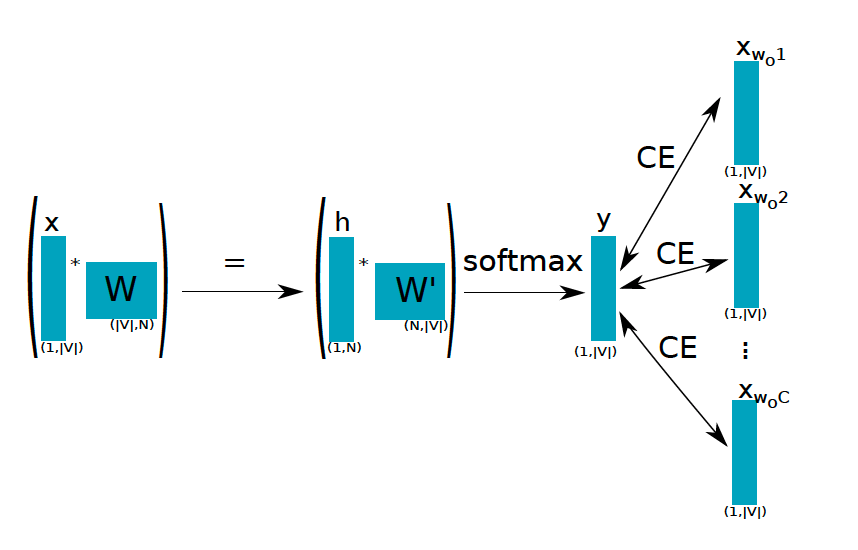

In [736]:
from IPython.display import Image
Image("images/skip.png")

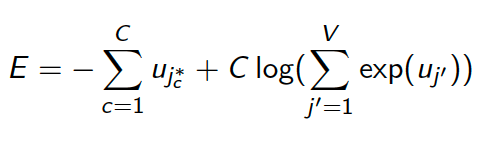

In [737]:
from IPython.display import Image
Image("images/erro-skip.png")

### Definiendo los Hiperparametros

Aqui definimos vários hiperparametros incluindo 

- `batch_size` (cantidad de amostras en un único lote) 
- `embedding_size` (tamaño de los embedding vectors) 
- `window_size` (tamaño de la ventana de contexto).

In [738]:
# Puntos de datos en un único lote. 
batch_size = 128

# Dimención del embedding vector.
embedding_size = 128

# Palabras a considerar a la izquierda y a la derecha
window_size = 4

# Conjunto aleatorio de palabras para avaliar la similaridad (vecinos más proximos)
valid_size = 16

# Avaliamos datapoints validos aleatoriamente desde una ventana grande
# para evitar ser deterministico
valid_window = 50

# Rango valido para avaliar
valid_examples = np.array(random.sample(range(valid_window), valid_size))
valid_examples = np.append(valid_examples,random.sample(range(vocabulary_size//5, (vocabulary_size//5)+valid_window), valid_size),axis=0)

# Número de ejemplos negativos para la mostra.
num_sampled = 32

### Definir Entradas y Salidas

Definición de los espacios reservados (placeholders) para alimentación de los datos de entrada y salida para el entrenamiento (cada uno del tamaño `batch_size`) y un tensor constante para ejemplos de validación.

In [739]:
tf.compat.v1.reset_default_graph()

# Datos de entrada de entrenamiento (IDs de palabras destino).
train_dataset = tf.compat.v1.placeholder(tf.int32, shape=[batch_size])

# Datos de etiquetas de entrada de entrenamiento (IDs de palabras de contexto)
train_labels = tf.compat.v1.placeholder(tf.int32, shape=[batch_size, 1])

# Datos de entrada de validación
valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

### Definir de parámetros del modelo y otras variables
Aqui definimos varias variables de TensorFlow, como una capa de embeddings (`embeddings`) y parámetros de la red neuronal (`softmax_weights` y `softmax_biases`)

In [740]:
# Variables

# Embedding layer, contiene las word embeddings
embeddings = tf.Variable(tf.random.uniform([vocabulary_size, embedding_size], -1.0, 1.0))

# Softmax Weights
softmax_weights = tf.Variable(
    tf.random.truncated_normal([vocabulary_size, embedding_size],
                        stddev=0.5 / math.sqrt(embedding_size)))

# Softmax Biases
softmax_biases = tf.Variable(tf.random.uniform([vocabulary_size],0.0,0.01))

### Definir los cálculos / computación del modelo

Primero, definimos una función de búsqueda para buscar los vectores embeddings correspondientes para un conjunto de entradas fornecidas. Con esto, definimos la función de pérdida negativa de muestreo `tf.nn.sampled_softmax_loss` que incluye los vectores embeddings e los parámetros de la rede neuronal previamente definidos.

In [741]:
# Modelo

# Procure un lote de embeddings.
embed = tf.nn.embedding_lookup(params=embeddings, ids=train_dataset)

# Calcule la pérdida de softmax usando una muestra de las etiquetas negativas a la vez.
loss = tf.reduce_mean(
    input_tensor=tf.nn.sampled_softmax_loss(
        weights = softmax_weights, biases = softmax_biases, inputs = embed,
        labels = train_labels, num_sampled = num_sampled, num_classes = vocabulary_size)
)

### Cálculo de similitud de palabras
Calculamos la similitud entre dos palabras dadas en términos de la distancia del coseno. Para hacer esto de manera eficiente, usamos operaciones de matriz.

In [742]:
# Calcula la similitud entre los ejemplos de minibatch(minilote) y todas los embeddings.
# Usamos la distancia del coseno:
norm = tf.sqrt(tf.reduce_sum(input_tensor=tf.square(embeddings), axis=1, keepdims=True))
normalized_embeddings = embeddings / norm
valid_embeddings = tf.nn.embedding_lookup(
params=normalized_embeddings, ids=valid_dataset)
similarity = tf.matmul(valid_embeddings, tf.transpose(a=normalized_embeddings))

### Optimizador de parámetros del modelo

Definimos una tasa de aprendizaje constante y un optimizador que utiliza el método Adagrad.

In [743]:
# Optimizador
optimizer = tf.compat.v1.train.AdagradOptimizer(1.0).minimize(loss)

## Entrenamiento del algoritmo Skip-Gram

In [744]:
# Cantidad de iteraciones de la RN
num_steps = 150001
skip_losses = []

# ConfigProto es una forma de proporcionar varias configuraciones necesarias para ejecutar el grafo
with tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(allow_soft_placement=True)) as session:

    # Inicializa las variables del grafo.
    tf.compat.v1.global_variables_initializer().run()
    print('Variables Inicializadas')
    average_loss = 0

    # Entrenando el modelo Word2vec para iteraciones num_step
    for step in range(num_steps):

        # Genera un lote de datos
        batch_data, batch_labels = generate_batch_skip_gram(batch_size, window_size)

        # LLena el feed_dict, ejecuta el optimizador (que minimiza la pérdida) y calcula la pérdida
        feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
        _, l = session.run([optimizer, loss], feed_dict=feed_dict)

        # Atualiza la variable de perdida média
        average_loss += l
        
        # Calcula la pérdida promedio a cada 2000 steps
        if (step+1) % 2000 == 0:
            average_loss = average_loss / 2000

            skip_losses.append(average_loss)

            # La pérdida promedio es una estimación de la pérdida en los últimos 2000 lotes.
            print('Error Promédio en el paso %d: %f' % (step+1, average_loss))
            average_loss = 0

        # Avalia la simlaridade de palabras del conjunto de validación a cada 10000 steps
        if (step+1) % 10000 == 0:
            sim = similarity.eval()

            # Calcula las top_k palabras más proximas para cada palabra de validación
            for i in range(valid_size):
                valid_word = reverse_dictionary[valid_examples[i]]

                # Número de vecinos más cercanos
                top_k = 8
                nearest = (-sim[i, :]).argsort()[1:top_k+1]
                # print("Nearest: ", nearest)
                log = 'Más Próximo de la palabra %s:' % valid_word
                for k in range(top_k):
                    close_word = reverse_dictionary[nearest[k]]
                    log = '%s %s,' % (log, close_word)
                print(log)

    skip_gram_final_embeddings = normalized_embeddings.eval()

# Salvar los vectores de palabras aprendidas y perdida a lo largo del tiempo
np.save('resultado/skip-gram_embeddings', skip_gram_final_embeddings)

with open('resultado/skip-gram_losses.csv', 'wt') as f:
    writer = csv.writer(f, delimiter=',')
    writer.writerow(skip_losses)

Variables Inicializadas
Error Promédio en el paso 2000: 4.015347
Error Promédio en el paso 4000: 3.629410
Error Promédio en el paso 6000: 3.586562
Error Promédio en el paso 8000: 3.501787
Error Promédio en el paso 10000: 3.475711
Más Próximo de la palabra city: backcross, zanuck, stunned, kaminaljuyu, blixen, dutch, inhalers, ornamentation,
Más Próximo de la palabra but: coit, nonfiction, dickey, magistrates, that, avidly, kikongo, 6.6,
Más Próximo de la palabra ): tx|align=left||-align=center|win|jimmy, ghafiqi, tingle, drapery, moves, undertaking, assembling, nylon-wrapped,
Más Próximo de la palabra an: a, 's, targets, this, super, jose, inquest, dahyabhai,
Más Próximo de la palabra ,: in, ., on, the, and, was, by, knox,
Más Próximo de la palabra (: 488, neglect, 26, donned, geographic, c+, eolophus, proto-celtic,
Más Próximo de la palabra :: stickiness, mysticeti, heic, phraseology, kharijites, until, synthesizing, weapons…,
Más Próximo de la palabra from: switchgrass, with, strathg

## Visualizar el aprendizado del algoritmo Skip-Gram

### Encontrar solo las palabras agrupadas

In [745]:
def find_clustered_embeddings(embeddings,distance_threshold,sample_threshold):
    '''
    Encuentra solo clústeres cercanos.
    Esto elimina lo embeddings de palabras más separadamente distribuidas y hace que la visualización sea más clara.
    Esto es útil para la vizualización del t-SNE.

    distance_threshold: distancia máxima entre dos puntos para calificar como vecinos
    sample_threshold: número de vecinos necesarios para sean considerado un clúster
    '''

    # Calcular la similaridade del cosseno
    cosine_sim = np.dot(embeddings,np.transpose(embeddings))
    norm = np.dot(np.sum(embeddings**2,axis=1).reshape(-1,1),np.sum(np.transpose(embeddings)**2,axis=0).reshape(1,-1))
    assert cosine_sim.shape == norm.shape
    cosine_sim /= norm

    # Poner las entras en la diagonal en zero; asi se evita que sea escogido como mayor
    np.fill_diagonal(cosine_sim, -1.0)

    argmax_cos_sim = np.argmax(cosine_sim, axis=1)
    mod_cos_sim = cosine_sim

    # Encuentrar los máximos en un loop para contar si haver más de n elementos por encima del umbral/limite
    for _ in range(sample_threshold-1):
        argmax_cos_sim = np.argmax(cosine_sim, axis=1)
        mod_cos_sim[np.arange(mod_cos_sim.shape[0]),argmax_cos_sim] = -1

    max_cosine_sim = np.max(mod_cos_sim,axis=1)

    return np.where(max_cosine_sim>distance_threshold)[0]

### Cálculos de la Visualización t-SNE de Word Embeddings Usando o Scikit-Learn

In [746]:
# Datos de amostra para el T-SNE manifold
num_points = 1000
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
print('Fitting embeddings en el T-SNE...')

# Obtener T-SNE manifold
selected_embeddings = skip_gram_final_embeddings[:num_points, :]
two_d_embeddings = tsne.fit_transform(selected_embeddings)

# Podar los T-SNE embeddings
print('Pruning los T-SNE embeddings...')
selected_ids = find_clustered_embeddings(selected_embeddings,.25,10)
two_d_embeddings = two_d_embeddings[selected_ids,:]

print('De un total de ', num_points, ' amostras, ', selected_ids.shape[0],' amostras fueron selecionadas para pruning')

Fitting embeddings en el T-SNE...
Pruning los T-SNE embeddings...
De un total de  1000  amostras,  584  amostras fueron selecionadas para pruning


### Agrupar los embedding reducido con el t-SNE con K-Means - Clustering

In [747]:
# Cantidad de clusters
n_clusters = 20

# Inicializar K-Means
kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=0).fit(two_d_embeddings)
kmeans_labels = kmeans.labels_

### Plotar los Resultados del t-SNE con Matplotlib

### Visualizar los Cluster en colecciones

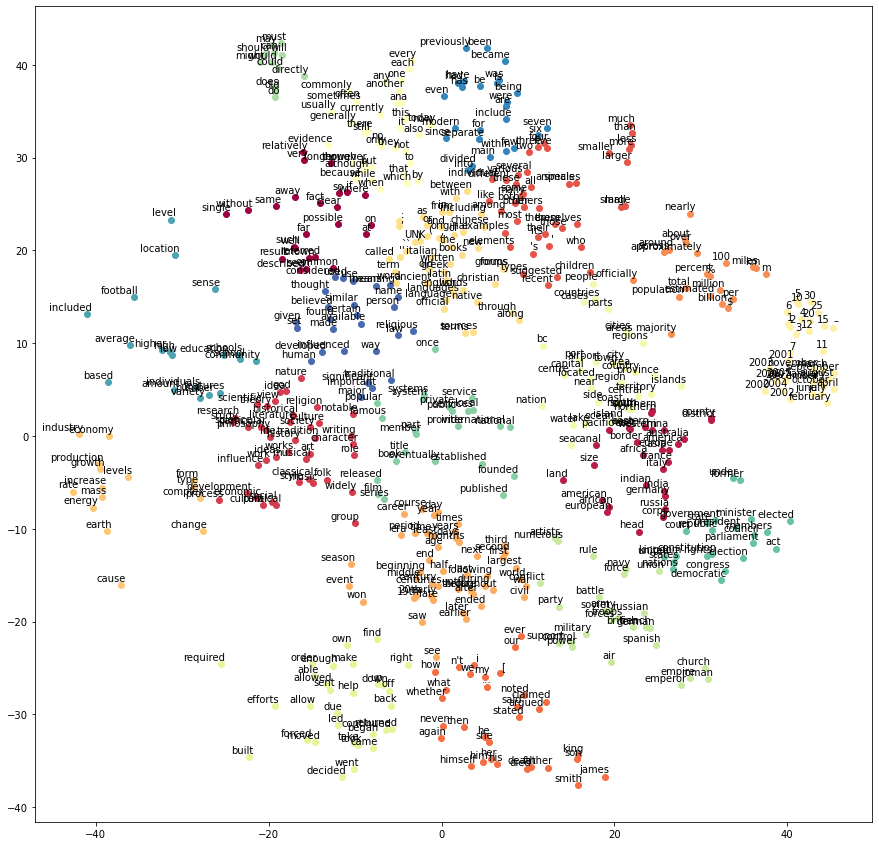

In [748]:
def plot(embeddings, labels, name):

    # Construir automaticamente un conjunto discreto de colores, un color para cada cluster
    cmap = pylab.cm.get_cmap("Spectral")
    label_colors = [cmap(float(i) /n_clusters) for i in range(n_clusters)]

    assert embeddings.shape[0] >= len(labels), 'Hay más rótulos que embeddings'
    
    pylab.figure(figsize=(15,15))

    # Plotar los embeddings y sus palabras correspondentes
    for i, (label,klabel) in enumerate(zip(labels,kmeans_labels)):
        x, y = embeddings[i,:]
        pylab.scatter(x, y, color=label_colors[klabel])

        pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom',fontsize=10)

    # Salvae el plot
    pylab.savefig(f'resultado/{name}.png')
    
    pylab.show()

words = [reverse_dictionary[i] for i in selected_ids]
plot(two_d_embeddings, words, 'skip_gram_word_embeddings')

In [749]:
document_classes = {}

# Buscar los items que estan en cada cluster
for inp, lbl in zip(words, kmeans_labels):
    if lbl not in document_classes:
        document_classes[lbl] = [inp]
    else:
        document_classes[lbl].append(inp)

for k,v in document_classes.items():
    print('\Palabras en el Cluster ',k)
    print('\t',v)

\Palabras en el Cluster  8
	 ['UNK', 'the', ',', '.', 'of', 'and', 'in', 'as', ')', '(', 'with', "''", 'from', '``', 'or', ';', ':', 'new', 'between', 'including', 'called', 'through', 'language', 'along', 'english', 'old', 'groups', 'term', 'written', 'chinese', 'original', 'word', 'official', 'greek', 'languages', 'forms', 'terms', 'latin', 'ancient', 'words', 'books', 'native', 'christian', 'italian', 'sources']
\Palabras en el Cluster  10
	 ['to', 'a', 'by', 'that', 'it', 'which', 'an', 'this', 'not', 'also', 'but', 'one', 'they', 'there', 'when', 'only', 'however', 'while', 'no', 'often', 'although', 'because', 'any', 'each', 'now', 'still', 'another', 'though', 'usually', 'generally', 'sometimes', 'today', 'every', 'evidence', 'currently', 'commonly']
\Palabras en el Cluster  18
	 ['is', 'was', 'for', 'are', 'be', 'were', 'have', 'has', 'had', 'been', 'into', 'became', 'being', 'since', 'include', 'even', 'within', 'modern', 'few', 'main', 'six', 'divided', 'seven', 'separate', '

# Algoritmo CBOW 

Partiendo de una ventana arbitraria de tamaño C, construiremos observaciones del tipo ([wI1 , . . . ,wIC ],wO). 

- Observación =>  ([wI1 , . . . ,wIC ], w0)
- Resultado => ([com, o, dessa, banda], cantor)

Repetir este proceso con diferentes ejemplos tomados del corpus se acumulará el efecto y, como resultado, las palabras con un contexto similar estarán muy juntas. Lo que hace el modelo es capturar las estadísticas de co-ocurrencia utilizando la distancia del coseno.

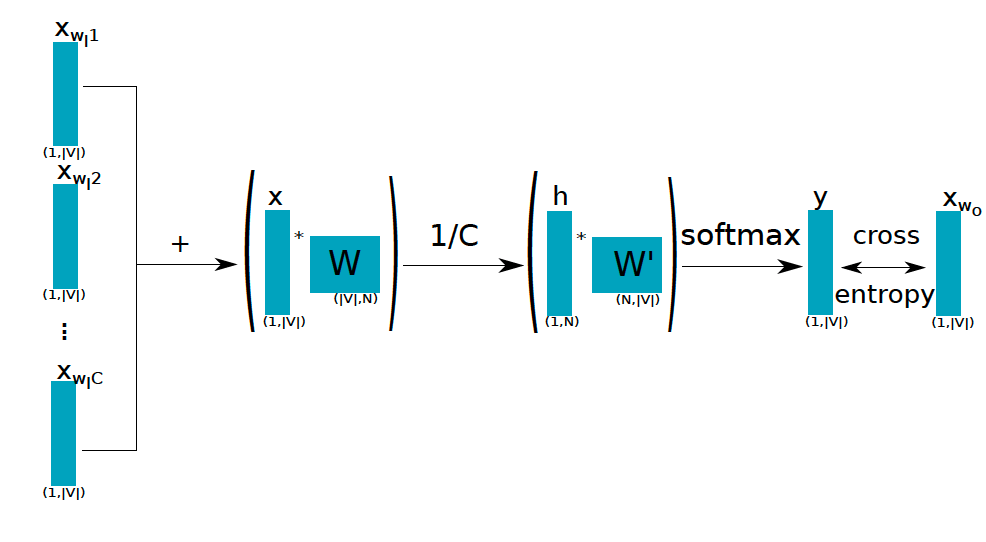

In [750]:
from IPython.display import Image
Image("images/cbow.png")

## Generando Lotes de Datos para el CBOW
Definir un nuevo generador de datos para el CBOW. La forma de la nueva matriz de entrada es (batch_size, context_window * 2). Es decir, un lote en CBOW captura todas las palabras en el contexto de una palabra dada.

In [751]:
data_index = 0

def generate_batch_cbow(batch_size, window_size):
    global data_index

    span = 2 * window_size + 1

    # Palabras-alvo (lote)
    batch = np.ndarray(shape=(batch_size,span-1), dtype=np.int32)
    # Palabras de contexto (rótulos)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    
    # En el buffer va todas las palabras del intervalo
    buffer = collections.deque(maxlen=span)

    # Llenar el buffer y actualizar data_index
    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)

    # Llernar las columnas de la matriz de lotes(batch) para cada indice del lote
    for i in range(batch_size):

        # Rotulo destino en el centro del buffer
        target = window_size

         # Llernar las columnas
        col_idx = 0
        for j in range(span):

            # Ignorar la palabra alvo(palabra del centro) al crear el lote
            if j==span//2:
                continue
            batch[i,col_idx] = buffer[j]
            col_idx += 1
        
        # Guardar el target en labels
        labels[i, 0] = buffer[target]

        # Agregar una nueva palabra en el buffer
        buffer.append(data[data_index])
        # Actualizar data_index
        data_index = (data_index + 1) % len(data)

    return batch, labels

for window_size in [1,2]:
    data_index = 0
    batch, labels = generate_batch_cbow(batch_size=8, window_size=window_size)
    print('\nCon window_size = %d:' % (window_size))
    print('    batch:', [[reverse_dictionary[bii] for bii in bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(8)])


Con window_size = 1:
    batch: [['propaganda', 'a'], ['is', 'concerted'], ['a', 'set'], ['concerted', 'of'], ['set', 'messages'], ['of', 'aimed'], ['messages', 'at'], ['aimed', 'influencing']]
    labels: ['is', 'a', 'concerted', 'set', 'of', 'messages', 'aimed', 'at']

Con window_size = 2:
    batch: [['propaganda', 'is', 'concerted', 'set'], ['is', 'a', 'set', 'of'], ['a', 'concerted', 'of', 'messages'], ['concerted', 'set', 'messages', 'aimed'], ['set', 'of', 'aimed', 'at'], ['of', 'messages', 'at', 'influencing'], ['messages', 'aimed', 'influencing', 'the'], ['aimed', 'at', 'the', 'opinions']]
    labels: ['a', 'concerted', 'set', 'of', 'messages', 'aimed', 'at', 'influencing']


### Definir de los hiperparámetros

- `batch_size` (cantidade de amostras em um único lote)
- `embedding_size` (tamaño de los vetores embedding) 
- `window_size` (tamaño de la ventana de contexto).

In [752]:
batch_size = 128

embedding_size = 128

window_size = 4

valid_size = 16

valid_window = 50

valid_examples = np.array(random.sample(range(valid_window), valid_size))
valid_examples = np.append(valid_examples,random.sample(range(vocabulary_size//5, vocabulary_size//5+valid_window), valid_size),axis=0)

num_sampled = 32

### Definir de entradas y salidas¶

Definición de los espacios reservados (placeholders) para alimentación de los datos de entrada y salida para el entrenamiento (cada uno del tamaño `batch_size`) y un tensor constante para ejemplos de validación.

In [753]:
tf.compat.v1.reset_default_graph()

# Datos de entrada de entrenamiento (IDs de las palabras destino).
train_dataset = tf.compat.v1.placeholder(tf.int32, shape=[batch_size,2*window_size])

# Datos de etiquetas de entrada de entrenamiento (IDs de las palabras de contexto)
train_labels = tf.compat.v1.placeholder(tf.int32, shape=[batch_size, 1])

# Datos de entrada de validación
valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

### Definindo Parâmetros do Modelo e Outras Variáveis
Nós agora definimos várias variáveis do TensorFlow, como uma camada embeddings (`embeddings`) e parâmetros de rede neural (`softmax_weights` e `softmax_biases`)

In [754]:
# Variáveis

# Embedding layer, contiene las word embeddings
embeddings = tf.Variable(tf.random.uniform([vocabulary_size, embedding_size], -1.0, 1.0,dtype=tf.float32))

# Softmax Weights
softmax_weights = tf.Variable(tf.random.truncated_normal([vocabulary_size, embedding_size],
                 stddev=0.5 / math.sqrt(embedding_size),dtype=tf.float32))

# Softmax Weights e Biases
softmax_biases = tf.Variable(tf.random.uniform([vocabulary_size],0.0,0.01))

### Definindo as Computações do Modelo

Primero, definimos una función de búsqueda para buscar los vectores embedding correspondentes para un conjunto de entradas fornecidas. Concretamente, definimos pesquisas embedding de 2 $ x $ `window_size`. En seguida, concatenamos todos los vetores pesquisados para formar una matriz de tamaño `[batch_size, embedding_size, 2 * window_size]`. Posteriormente, calculamos la média de las pesquisas embedding para produzir um embedding médio de tamanho `[batch_size, embedding_size]`. Con eso, definimos la función de pérdida negativa de muestreo `tf.nn.sampled_softmax_loss` que incluye los vetores embedding y los parámetros de rede neurales previamente definidos.

In [755]:
# Modelo

# Hacer búsquedas de embeddings para cada columna en el espacio reservado de entrada
# y, en seguida, calcular la média para produzir un vetor de palabra embedding_size
stacked_embedings = None
print('Definiendo %d embedding de pesquisas representando cada palabra en el contexto'%(2*window_size))

for i in range(2*window_size):
    embedding_i = tf.nn.embedding_lookup(params=embeddings, ids=train_dataset[:,i])
    x_size,y_size = embedding_i.get_shape().as_list()
    if stacked_embedings is None:
        stacked_embedings = tf.reshape(embedding_i,[x_size,y_size,1])
    else:
        stacked_embedings = tf.concat(axis=2,values=[stacked_embedings,tf.reshape(embedding_i,[x_size,y_size,1])])

assert stacked_embedings.get_shape().as_list()[2]==2*window_size
print("Stacked embedding size: %s"%stacked_embedings.get_shape().as_list())

mean_embeddings =  tf.reduce_mean(input_tensor=stacked_embedings,axis=2,keepdims=False)
print("Reduced mean embedding size: %s"%mean_embeddings.get_shape().as_list())

# Calculo de la perdida del softmax usando una amuestra de los rótulos/labels negativos de cada vez.
# Las entradas son los embeddings de las palabras del dataset de entrenamiennto
# Con la perdida, se optimiza los pesos, vieses y embeddings
loss = tf.reduce_mean(
    input_tensor=tf.nn.sampled_softmax_loss(weights=softmax_weights, biases=softmax_biases, inputs=mean_embeddings,
                           labels=train_labels, num_sampled=num_sampled, num_classes=vocabulary_size))

Definiendo 8 embedding de pesquisas representando cada palabra en el contexto
Stacked embedding size: [128, 128, 8]
Reduced mean embedding size: [128, 128]


### Cálculo de similitud de palabras
Calcular la similitud entre los ejemplos de minibatch y todos los embeddings.

In [756]:
norm = tf.sqrt(tf.reduce_sum(input_tensor=tf.square(embeddings), axis=1, keepdims=True))
normalized_embeddings = embeddings / norm
valid_embeddings = tf.nn.embedding_lookup(params=normalized_embeddings, ids=valid_dataset)
similarity = tf.matmul(valid_embeddings, tf.transpose(a=normalized_embeddings))

### Optimizador de parámetros del modelo

Definimos una tasa de aprendizaje constante y un optimizador que utiliza el método Adagrad.

In [757]:
# Optimizador
optimizer = tf.compat.v1.train.AdagradOptimizer(1.0).minimize(loss)

## Treinando o Algoritmo CBOW 

In [758]:
# Cantidad de iteraciones de la RN
num_steps = 150001
cbow_losses = []

# ConfigProto es una forma de proporcionar varias configuraciones necesarias para ejecutar el grafo
with tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(allow_soft_placement=True)) as session:

     # Inicializar las variables del grafo.
    tf.compat.v1.global_variables_initializer().run()
    print('Variables Inicializadas')

    average_loss = 0

    # Entrenando el modelo Word2vec para iteraciones num_step
    for step in range(num_steps):

         # Genera un lote de datos
        batch_data, batch_labels = generate_batch_cbow(batch_size, window_size)
        
        # LLena el feed_dict, ejecuta el optimizador (que minimiza la pérdida) y calcula la pérdida
        feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
        _, l = session.run([optimizer, loss], feed_dict=feed_dict)

        # Atualiza la variable de perdida média
        average_loss += l
        
        # Calcula la pérdida promedio a cada 2000 steps
        if (step+1) % 2000 == 0:
            if step > 0:
                average_loss = average_loss / 2000
            cbow_losses.append(average_loss)
            
            # La pérdida promedio es una estimación de la pérdida en los últimos 2000 lotes.
            print('Error Promédio en el paso %d: %f' % (step+1, average_loss))
            average_loss = 0

        # Avalia la simlaridade de palabras del conjunto de validación a cada 10000 steps
        if (step+1) % 10000 == 0:
            sim = similarity.eval()
            
            # Calcula las top_k palabras más proximas para cada palabra de validación
            for i in range(valid_size):
                valid_word = reverse_dictionary[valid_examples[i]]
                
                # Número de vecinos más cercanos
                top_k = 8
                nearest = (-sim[i, :]).argsort()[1:top_k+1]
                log = 'Más Cerca de la palabra %s:' % valid_word
                for k in range(top_k):
                    close_word = reverse_dictionary[nearest[k]]
                    log = '%s %s,' % (log, close_word)
                print(log)
    cbow_final_embeddings = normalized_embeddings.eval()

# Salvar los vectores de palabras aprendidas y perdida a lo largo del tiempo
np.save('resultado/cbow_embeddings', cbow_final_embeddings)

with open('resultado/cbow_losses.csv', 'wt') as f:
    writer = csv.writer(f, delimiter=',')
    writer.writerow(cbow_losses)

Variables Inicializadas
Error Promédio en el paso 2000: 3.741846
Error Promédio en el paso 4000: 3.302907
Error Promédio en el paso 6000: 3.185795
Error Promédio en el paso 8000: 3.122780
Error Promédio en el paso 10000: 3.064775
Más Cerca de la palabra their: his, helismaa, microorganism, jeopardized, fueled, inoki, bollettieri, communes,
Más Cerca de la palabra most: 1710., 40,000, ogaim, varsity, salinities, bahamian, stratified, jared,
Más Cerca de la palabra which: evaluating, but, 79, beetham, critical, grachtengordel, alabama, number-theoretical,
Más Cerca de la palabra 's: transcript, again, his, nuorgam, nuys, tunes, apologists, reconvened,
Más Cerca de la palabra in: conning, forbade, eider, philip, creatine, tendered, exemplars, sailor,
Más Cerca de la palabra was: is, were, specifying, became, mandinka, has, had, supersemar,
Más Cerca de la palabra .: ;, ,, hermon, affirmed, uthulwana, :, burgundian, nationhood,
Más Cerca de la palabra as: gannon, cross-country, basin, kend

## Visualizar el aprendizado del algoritmo CBOW

### Cálculos de la Visualización t-SNE de Word Embeddings Usando o Scikit-Learn

In [759]:
# Datos de amostra para el T-SNE manifold
num_points = 1000
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
print('Fitting embeddings en el T-SNE...')

# Obtener T-SNE manifold
selected_embeddings = cbow_final_embeddings[:num_points, :]
two_d_embeddings = tsne.fit_transform(selected_embeddings)

# Podar los T-SNE embeddings
print('Pruning los T-SNE embeddings...')

# Encontrar solo las palabras agrupadas
selected_ids = find_clustered_embeddings(selected_embeddings,.25,10)
two_d_embeddings = two_d_embeddings[selected_ids,:]

print('De un total de ', num_points, ' amostras, ', selected_ids.shape[0],' amostras fueron selecionadas para pruning')

Fitting embeddings en el T-SNE...
Pruning los T-SNE embeddings...
De un total de  1000  amostras,  704  amostras fueron selecionadas para pruning


### Agrupar los embedding reducido con el t-SNE con K-Means - Clustering

In [760]:
# Cantidad de clusters
n_clusters = 20

# Inicializar K-Means
kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=0).fit(two_d_embeddings)
kmeans_labels = kmeans.labels_

### Plotar los Resultados del t-SNE con Matplotlib

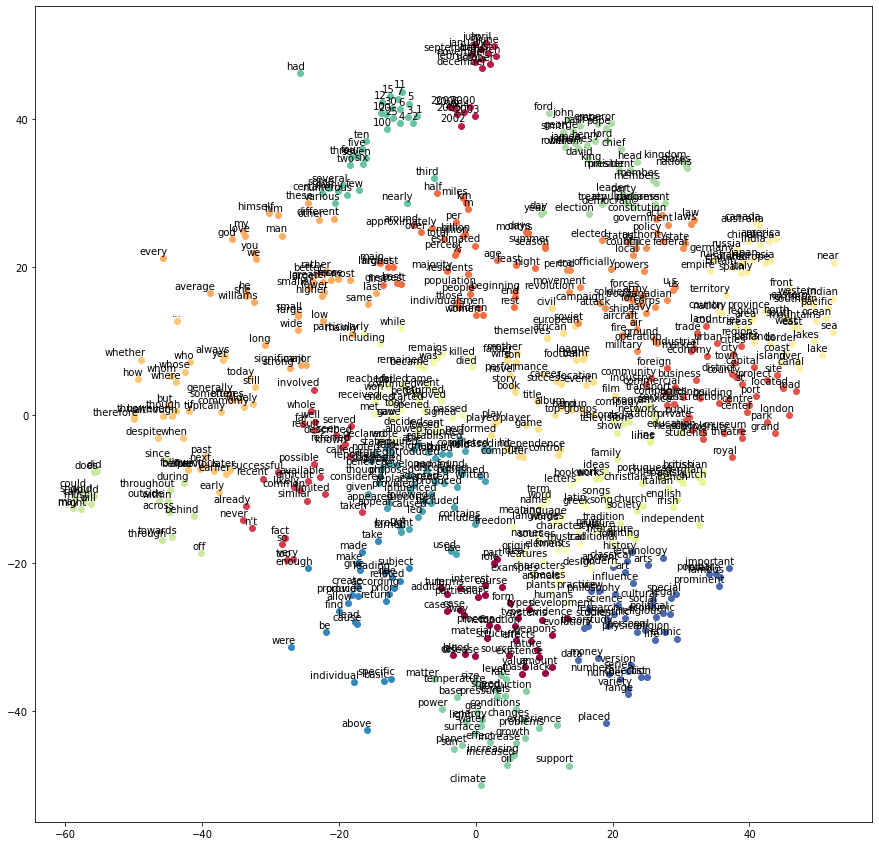

In [761]:
words = [reverse_dictionary[i] for i in selected_ids]
plot(two_d_embeddings, words, 'cbow_word_embeddings')

### Visualizar los Cluster en colecciones

In [762]:
document_classes = {}

# Buscar los items que estan en cada cluster
for inp, lbl in zip(words, kmeans_labels):
    if lbl not in document_classes:
        document_classes[lbl] = [inp]
    else:
        document_classes[lbl].append(inp)

for k,v in document_classes.items():
    print('\Palabras en el Cluster ',k)
    print('\t',v)

\Palabras en el Cluster  11
	 ['is', 'was', 'while', 'became', 'including', 'began', 'took', 'came', 'continued', 'wrote', 'won', 'died', 'particularly', 'lost', 'remained', 'received', 'moved', 'allowed', 'remains', 'started', 'saw', 'gave', 'sent', 'went', 'returned', 'killed', 'reached', 'met', 'forced', 'passed', 'declared', 'failed', 'decided', 'opened', 'signed', 'ended']
\Palabras en el Cluster  18
	 ['be', 'were', 'made', 'due', 'according', 'make', 'take', 'above', 'individual', 'cause', 'leading', 'provide', 'related', 'lead', 'enough', 'produce', 'subject', 'return', 'specific', 'find', 'create', 'allow', 'give', 'prior', 'basic']
\Palabras en el Cluster  6
	 ['he', 'other', 'most', 'more', 'these', 'large', 'major', 'she', 'him', 'same', 'small', 'different', 'long', 'last', 'less', 'rather', 'every', 'we', 'significant', 'god', 'himself', 'man', 'low', 'higher', 'you', 'average', 'larger', 'strong', 'lower', 'greater', 'smaller', 'my', 'wide', 'better', 'mainly', 'williams